## 載入相關套件並載入我們的股價資料

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#從Yahoo finance下載股價資料，載入過去五年每日大立光(3008)收盤資料
data = pd.read_csv(r'C:\Users\npc94\OneDrive\桌面\3008.TW.csv',index_col=0,parse_dates=True)

## 檢視前五筆資料

In [2]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-16,4220.0,4250.0,4195.0,4250.0,3802.673584,313000.0
2017-01-17,4260.0,4410.0,4260.0,4400.0,3936.885498,784000.0
2017-01-18,4390.0,4450.0,4370.0,4445.0,3977.148926,574000.0
2017-01-19,4410.0,4420.0,4275.0,4295.0,3842.937012,701000.0
2017-01-20,4280.0,4390.0,4220.0,4390.0,3927.937744,717000.0


## 檢視最後五筆資料

In [3]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-10,2485.0,2510.0,2445.0,2475.0,2443.781006,1145001.0
2022-01-11,2490.0,2505.0,2440.0,2470.0,2438.843994,836995.0
2022-01-12,2465.0,2480.0,2360.0,2375.0,2375.000000,1418638.0
2022-01-13,2405.0,2435.0,2360.0,2375.0,2375.000000,1084432.0
2022-01-14,2210.0,2220.0,2140.0,2140.0,2140.000000,1552174.0


## 繪製大立光的對數報酬直方圖

<AxesSubplot:>

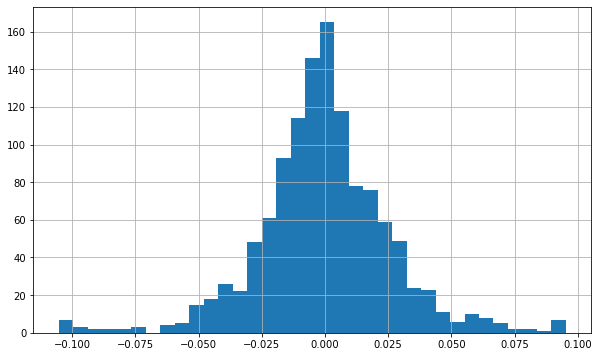

In [4]:
data['return'] = np.log(data['Close']/data['Close'].shift(1))
data.dropna(inplace=True)
data['direction']=np.sign(data['return']).astype(int)
data['return'].hist(bins=35,figsize=(10,6))

## 將對數報酬落後2期來建立特徵資料，並將他與報酬資料視覺化

In [5]:
lags=2
def create_lags(data):
    global cols
    cols=[]
    for lag in range(1, lags+1):
        col='lag_{}'.format(lag)
        data[col]=data['return'].shift(lag)
        cols.append(col)

In [6]:
create_lags(data)

## 檢視新的資料

In [7]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,return,direction,lag_1,lag_2
Date,,,,,,,,,,
2017-01-17,4260.0,4410.0,4260.0,4400.0,3936.885498,784000.0,0.034686,1,NaN,NaN
2017-01-18,4390.0,4450.0,4370.0,4445.0,3977.148926,574000.0,0.010175,1,0.034686,NaN
2017-01-19,4410.0,4420.0,4275.0,4295.0,3842.937012,701000.0,-0.034328,-1,0.010175,0.034686
2017-01-20,4280.0,4390.0,4220.0,4390.0,3927.937744,717000.0,0.021878,1,-0.034328,0.010175
2017-01-23,4380.0,4455.0,4335.0,4355.0,3896.621582,538000.0,-0.008005,-1,0.021878,-0.034328


In [8]:
data.dropna(inplace=True)

## 依據特徵與標籤進行繪圖

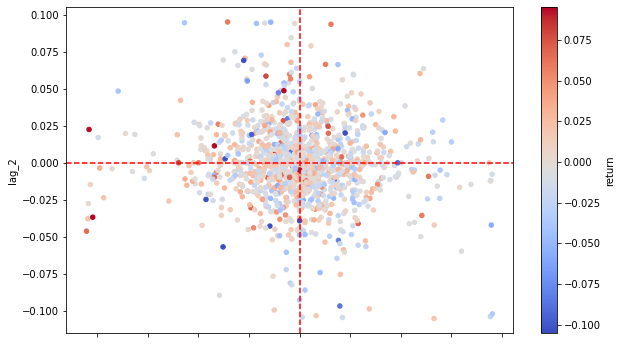

In [9]:
data.plot.scatter(x='lag_1',y='lag_2',c='return',cmap='coolwarm',figsize=(10,6),colorbar=True)
plt.axvline(0,c='r',ls='--')
plt.axhline(0,c='r',ls='--')

## 載入K-means資料分群套件

In [10]:
from sklearn.cluster import KMeans

## 選擇讓演算法處理的兩個群體

In [11]:
model = KMeans(n_clusters=2,random_state=0)

In [12]:
model.fit(data[cols])
KMeans(algorithm='auto',copy_x=True,init='k-means++',max_iter=300,n_clusters=2,n_init=10,random_state=0,tol=0.001,verbose=0)

KMeans(n_clusters=2, random_state=0, tol=0.001)

In [13]:
data['pos_clus']=model.predict(data[cols])

## 根據群體值來選擇位置

In [14]:
data['pos_clus']=np.where(data['pos_clus']==1,-1,1)

In [15]:
data['pos_clus'].values

array([-1, -1,  1, ...,  1, -1,  1])

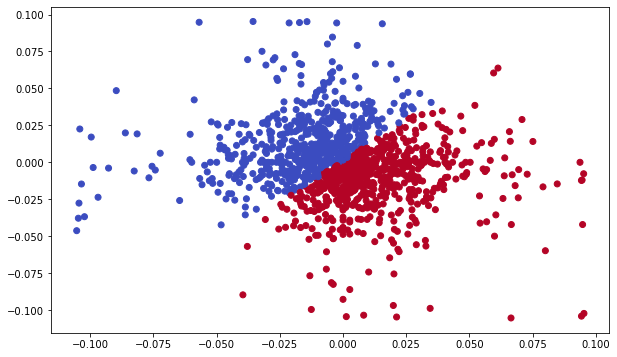

In [16]:
plt.figure(figsize=(10,6))
plt.scatter(data[cols].iloc[:,0],data[cols].iloc[:,1],c=data['pos_clus'],cmap='coolwarm')

In [17]:
data['strat_clus']=data['pos_clus']*data['return']

In [18]:
data[['return','strat_clus']].sum().apply(np.exp)

return        0.484688
strat_clus    0.230354
dtype: float64

## 預測的正確與錯誤次數

In [19]:
(data['direction']==data['pos_clus']).value_counts()

False    669
True     544
dtype: int64

## 大立光隨著時間變化的績效

<AxesSubplot:xlabel='Date'>

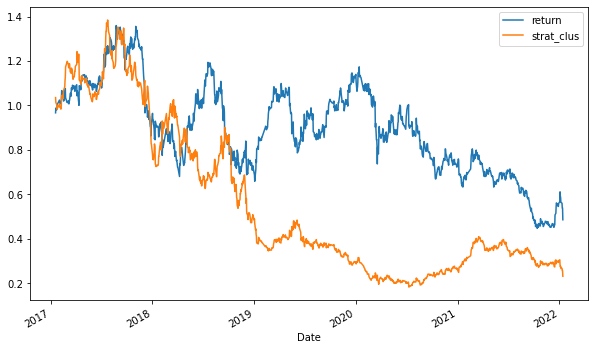

In [20]:
data[['return','strat_clus']].cumsum().apply(np.exp).plot(figsize=(10,6))

## 載入機器學習所需的套件

In [21]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import pandas as pd
import numpy as np

## 提供bins參數，將特徵值數字化

In [22]:
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col +'_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)
        cols_bin.append(col_bin)

In [23]:
create_bins(data)

## 顯示數字化的特徵值與標籤值

In [24]:
data[cols_bin + ['direction']].head()

,lag_1_bin,lag_2_bin,direction
Date,,,
2017-01-19,1,1,-1
2017-01-20,0,1,1
2017-01-23,1,0,-1
2017-01-24,0,1,1
2017-02-02,1,0,1


In [25]:
grouped = data.groupby(cols_bin + ['direction'])

## 顯示特徵組合可能移動的狀況的頻率

In [26]:
grouped.size()

lag_1_bin  lag_2_bin  direction
0          0          -1           119
                       0            17
                       1           144
           1          -1           161
                       0            17
                       1           151
1          0          -1           180
                       0            13
                       1           136
           1          -1           150
                       0            12
                       1           113
dtype: int64

## 轉換DataFrame物件，加入頻率物件

In [27]:
res = grouped['direction'].size().unstack(fill_value=0)

##突顯每一個特徵值組合的最高頻率值

In [28]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color:yellow' if v else ''for v in is_max]

In [29]:
res.style.apply(highlight_max, axis=1)

## 從頻率發現事實並將它轉換成交易策略

In [30]:
data['pos_freq'] = np.where(data[cols_bin].sum(axis=1) ==2,-1,1)

In [31]:
(data['direction'] == data['pos_freq']).value_counts()

False    632
True     581
dtype: int64

In [32]:
data['strat_freq'] = data['pos_freq']*data['return']

In [33]:
data[['return', 'strat_freq']].sum().apply(np.exp)

return        0.484688
strat_freq    1.685870
dtype: float64

<AxesSubplot:xlabel='Date'>

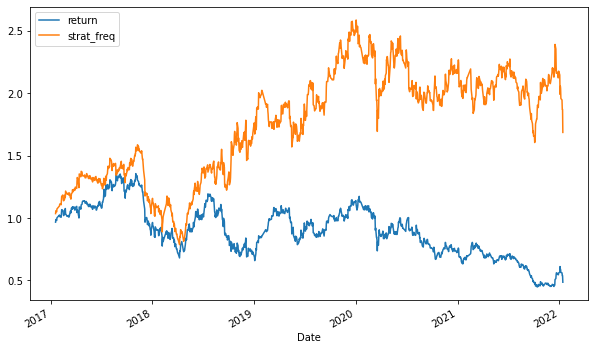

In [34]:
data[['return', 'strat_freq']].cumsum().apply(np.exp).plot(figsize=(10,6))

In [35]:
C = 1

In [36]:
models = {'log_reg':linear_model.LogisticRegression(C=C),'gauss_nb':GaussianNB(),'svm':SVC(C=C)}

## 擬合所有模型的函式

In [37]:
def fit_models(data):
    mfit = {model:models[model].fit(data[cols_bin], data['direction']) for model in models.keys()}

In [38]:
fit_models(data)

## 用擬合的模型推導所有部位值的函示

In [39]:
def derive_positions(data):
    for model in models.keys():
        data['pos_'+ model] = models[model].predict(data[cols_bin])

In [40]:
derive_positions(data)

In [41]:
def evaluate_strats(data):
    global sel
    sel = []
    for model in models.keys():
        col = 'strat_'+ model
        data[col] = data['pos_'+model]*data['return']
        sel.append(col)
    sel.insert(0, 'return')

In [42]:
evaluate_strats(data)

In [43]:
sel.insert(1, 'strat_freq')

## 這個函式可評估所有產生的交易策略

In [44]:
data[sel].sum().apply(np.exp)

return            0.484688
strat_freq        1.685870
strat_log_reg     5.898722
strat_gauss_nb    6.278775
strat_svm         5.898722
dtype: float64

<AxesSubplot:xlabel='Date'>

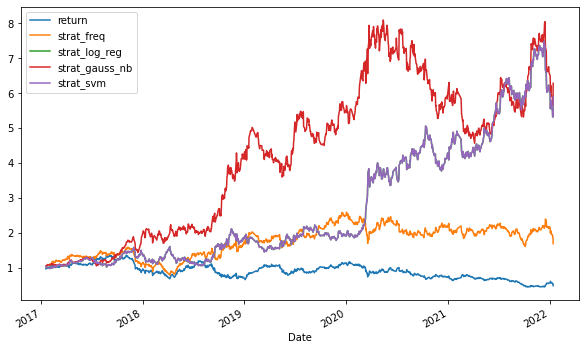

In [45]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10,6))

## 將資料分為訓練組以及測試組

In [46]:
split = int(len(data)*0.5)

## 用訓練資料來訓練所有分類演算法

In [47]:
train = data.iloc[:split].copy()

## 用測試資料來測試所有分類演算法

In [48]:
fit_models(train)

In [49]:
test = data.iloc[split:].copy()

In [50]:
derive_positions(test)

In [51]:
evaluate_strats(test)

In [52]:
test[sel].sum().apply(np.exp)

return            0.506509
strat_log_reg     1.146552
strat_gauss_nb    1.146552
strat_svm         1.146552
dtype: float64

<AxesSubplot:xlabel='Date'>

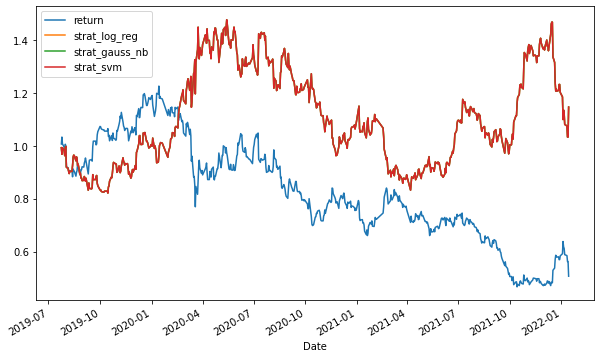

In [53]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10,6))

## 載入機器學習套件

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
train, test = train_test_split(data, test_size=0.5,shuffle=True, random_state=100)

## 按照時間順序複製與回傳訓練與測試資料集

In [56]:
train = train.copy().sort_index()

In [57]:
train[cols_bin].head()

,lag_1_bin,lag_2_bin
Date,,
2017-01-19,1,1
2017-01-20,0,1
2017-01-23,1,0
2017-02-03,1,1
2017-02-06,0,1


In [58]:
test = test.copy().sort_index()

In [59]:
fit_models(train)

In [60]:
derive_positions(test)

In [61]:
evaluate_strats(test)

In [62]:
test[sel].sum().apply(np.exp)

return            1.125928
strat_log_reg     1.152889
strat_gauss_nb    1.152889
strat_svm         1.152889
dtype: float64

<AxesSubplot:xlabel='Date'>

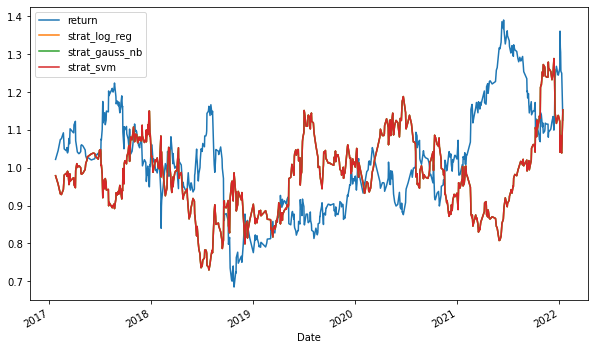

In [63]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10,6))

In [64]:
from sklearn.neural_network import MLPClassifier

In [65]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=2* [250], random_state=1)

In [66]:
%time model.fit(data[cols_bin], data['direction'])

Wall time: 433 ms


MLPClassifier(alpha=1e-05, hidden_layer_sizes=[250, 250], random_state=1,
              solver='lbfgs')

In [67]:
MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,hidden_layer_sizes=[250, 250], learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=[250, 250], random_state=1,
              solver='lbfgs')

In [68]:
data['pos_dnn_sk'] = model.predict(data[cols_bin])

In [69]:
data['strat_dnn_sk'] = data['pos_dnn_sk']*data['return']

In [70]:
data[['return', 'strat_dnn_sk']].sum().apply(np.exp)

return          0.484688
strat_dnn_sk    5.898722
dtype: float64

<AxesSubplot:xlabel='Date'>

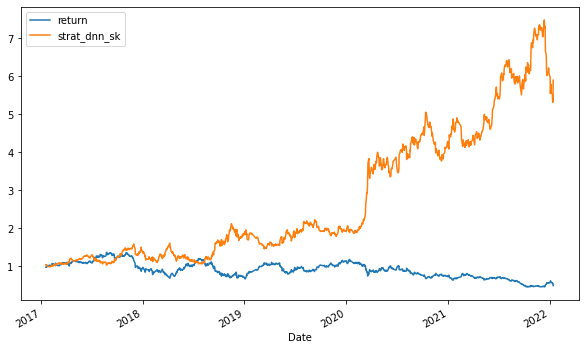

In [71]:
data[['return', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10,6))

In [72]:
train ,test = train_test_split(data, test_size=0.5,random_state=1000)

In [73]:
train = train.copy().sort_index()

In [74]:
test = test.copy().sort_index()

In [75]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=500, hidden_layer_sizes= 3 * [500], random_state=1)

In [76]:
%time model.fit(train[cols_bin], train['direction'])

Wall time: 2.13 s


MLPClassifier(alpha=1e-05, hidden_layer_sizes=[500, 500, 500], max_iter=500,
              random_state=1, solver='lbfgs')

In [77]:
MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',  beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[500, 500, 500], learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=[500, 500, 500], max_iter=500,
              random_state=1, solver='lbfgs')

In [78]:
test['pos_dnn_sk'] = model.predict(test[cols_bin])

In [79]:
test['strat_dnn_sk'] = test['pos_dnn_sk']*test['return']

In [80]:
test[['return', 'strat_dnn_sk']].sum().apply(np.exp)

return          0.750699
strat_dnn_sk    2.449193
dtype: float64

<AxesSubplot:xlabel='Date'>

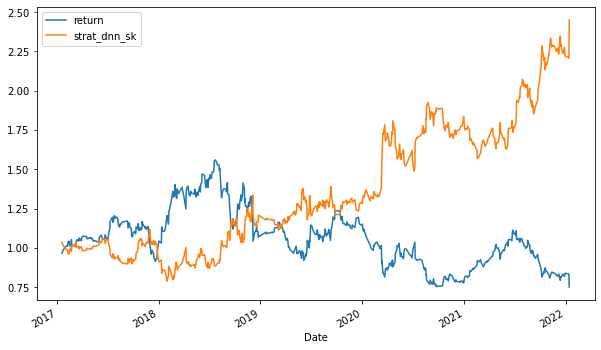

In [81]:
test[['return', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10,6))